# Scientific Computing - EMAT30008 -  Report

This report will outline the code produced for this module as a library able to compute limit cycles of ODE's and PDE's as well as confirming the steady-states of diffusive PDE's

# A brief summary of your software (30% of the marks)

Structure of the modules,
How inputs are taken,
Checks,
Outputs

The summary of the software should explain the capabilities of your software (e.g., what methods are implemented — there is no need to explain how the methods work) and provide some examples, with results, of it in use. Code samples may be appropriate but they should be short and for the purpose of demonstration only.

Start with the ODE solvers:

1. Present the difference between the solvers for solving a few steps of ODE of n dim
2. Isolate a periodic solution using shooting and know parameters
3. Trace out the parameter-period curve using both natural and pseudo-arclength continuation methods.


In [1]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
from helpers import *

### ODE solvers
 - solve_to and solvers.py: 
These methods are used as the building blocks for all the other integration code

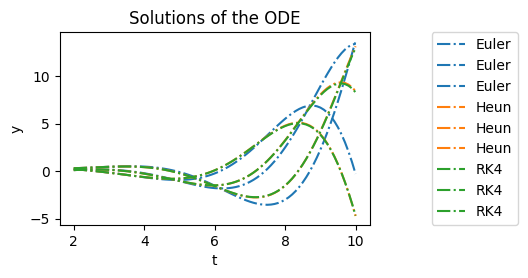

In [34]:
from solve_to import solve_to
from test_equations import ode3

# define the initial conditions
y0, t0, t1, delta_t = [0.3, 0.1, 0.2], 2, 10, 0.1 

plt.figure(figsize=(4, 2.5))
# solve the ODE
for i, method in enumerate(['Euler', 'Heun', 'RK4']):
    Y, t = solve_to(ode3, y0, t0, t1, delta_t, method)
    # plot the solution
    plt.plot(t, Y, label=method, color='C'+str(i), linestyle='-.')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Solutions of the ODE')
plt.legend(loc=(1.2,0))
plt.show()

The solvers (solvers.py) that I have implemented are single step integrators using the Euler, RK4 and Heun method. These methods provide different accuracies (with Heul and RK4 being much more accurate than Euler). The functions are incorporated in the solve_to method which allows the integration of a function between 2 times. The functions take any number of dimensions as long as the function is provided in a first order form. The plot above shows a 3 dimensional ODE solved by all three methods.

### Discretisation, shooting_setup, shooting_solve
These methods are made in such a way that the Discretisation class will provide a discretisation of a given problem (either [currently] using a shooting method or a linear [none] method). This class is made so that adding other discretisations is simple and the outputs and inputs are always the same. This is build on using the continuation class.

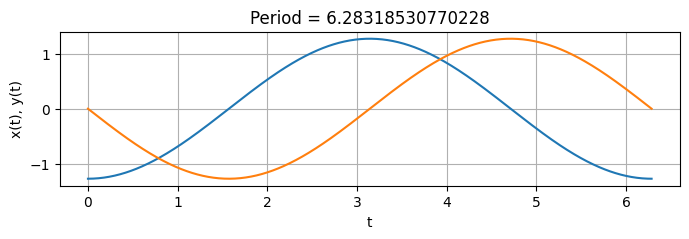

In [35]:
from shooting import Discretisation, shooting_solve
from test_equations import hopf

discret = Discretisation() # create the discretisation object
# initial guess
Y0, T, b = [0.1,0.1], 10, 1
u0 = np.append(Y0, T)

# solve the ode using the shooting method - here the discretisation is using shooting
fun = discret.shooting_setup(hopf, Y0, T=T, args=b)
Y0, T0 = shooting_solve(fun, u0)

# solve for one period of the solution
Y,t = solve_to(hopf, Y0, 0, T0, args=b)
plt.figure(figsize=(8,2))
plt.plot(t, Y)
plot_help(plt, 't', 'x(t), y(t)', 'Period = ' + str(T0))

The discretisation using shooting (or linear method) are then used by the Continuation class. The continuation class contains the natural continuation method where for any given equation, starting point and parameters, the method aims to find the root of the discretised problem (whether its a root of an equation or a shooting problem identifying the limit cycle) at each parameter value and then incrementing the parameter to follow the solution.

All the continuation methods will take as input: function, x0, starting param, vary param (idx), step, max_steps, discretisation type. The Continuation class allows for simple inclusion of other methods - such at the pseudo-arclength continuation method. The discretisation used to make the function F(u) = 0 to be solved is modular and so can be accessed for other methods once they are developed.

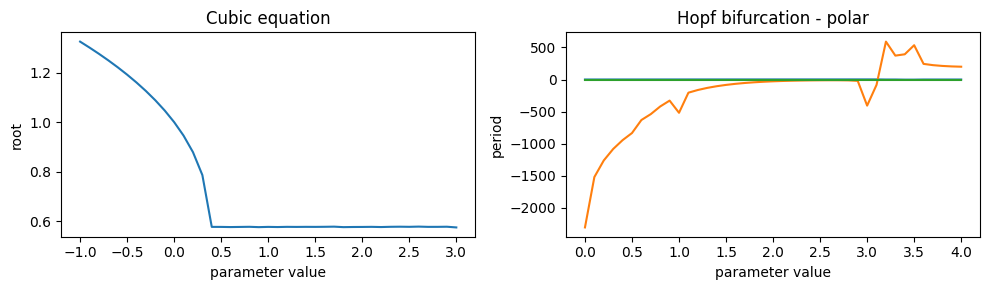

In [36]:
from continuation import Continuation
import scipy.optimize
from test_equations import cubic, hopf_polar

# create continuation class
cont = Continuation(solver=scipy.optimize.root)
# create discretisation class
discret = Discretisation()
x0 , p0 = 1, -1
# solve for the root of the cubic equation using no discretisation
X, C = cont.nat_continuation(cubic, x0, p0, vary_p=0, step=0.1, max_steps=40, discret=None)
# plot the solution
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].plot(C, X)
ax[0].set_xlabel('parameter value')
ax[0].set_ylabel('root')
ax[0].set_title('Cubic equation')

# now need to test natural continuation with a differential equation - Hopf bifurcation and shooting discretisation
discret = Discretisation().shooting_setup
x0 , p0 = [1, 1,1], [0, 1]
# solve for the root of the hopf equation using shooting discretisation
X, C = cont.nat_continuation(hopf_polar, x0, p0, step=0.1, max_steps=40, discret=discret)
# plot the solution
ax[1].plot(C, X)
ax[1].set_xlabel('parameter value')
ax[1].set_ylabel('period')
ax[1].set_title('Hopf bifurcation - polar')
fig.tight_layout()

The continuation above shows the performance of the natural continuation method for both a simple algebraic equation and an ODE


## PDE solvers 

Solver profiling and showing modularity
1. BVP solver
2. PDE solver
- Explicit methods
- Implicit methods

1. The bvp_solver contains the ODE object and the Solver class. The ODE object stores all the coefficients, boundary conditions, functions and arguments associated with an ODE equation in 2nd order form. The Solver class allows the equation, number of interior points and the solving method to be specified and the problem initialised. The solver then solves problem giving the solution values u = solver.solve() (implementing the method defined earlier). The solver object stores the solutions u and the grid x. These modules allow for a source term to be included (as a function of x,u and args).

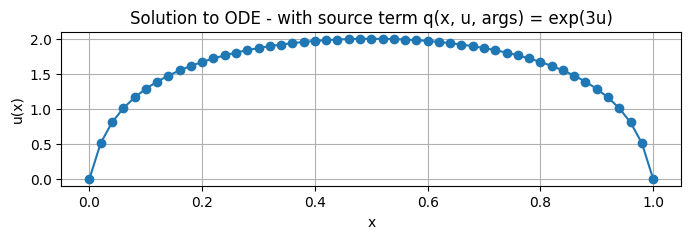

In [38]:
# define the BVP ODE to solve
m, c, k,  bound_type, alpha, beta, a, b, args = 1, 1, 1, 'DD', 0, 0, 0, 1, (3,)
q = lambda x, u, *args: np.exp(args[0] * u) # lambda function for q(x, u, args)

# create the ODE object
from bvp_solver import ODE
ode = ODE(m, c, k, q, bound_type, alpha, beta, a, b, *args)
# create the solver object
from bvp_solver import Solver
N , method = 50, 'scipy'
solver = Solver(ode, N, method)
# solve the ODE
u = solver.solve()
x = solver.x

plt.figure(figsize=(8,2))
# plot the solution
plt.plot(x, u, 'o-')
plot_help(plt, 'x', 'u(x)', 'Solution to ODE - with source term q(x, u, args) = exp(3u)')


2. PDE solver:
The pde_solver module functions in the same way as the ode_solver module. The PDE object contains the same all the coefficients, boundary conditions, functions (starting condition and source term) and arguments associated with an PDE equation in 2nd order form. The main difference is that there are different methods allowed to be specified in the Solver class and that the source function can be non-linear and a function of (x, t, u, args).

In [42]:
# demo of some of the PDE solvers - two examples
from pde_solver import PDE, Solver

# make the PDE object
f, m, q, bound_type, alpha, beta, a, b, args = lambda x: np.sin((np.pi*(x-a)/b-a)),1,1,'DD', 0, 0, 0, 1, (3,) # linear source term
pde = PDE(f, m, q, bound_type, alpha, beta, a, b, *args)
q = lambda x, t, u, *args: 2*u # lambda function for q(x, u, args) - non linear source term
hard_pde = PDE(f, m, q, bound_type, alpha, beta, a, b, *args)

# create the solver object with a variety of methods
solver = Solver(pde, N=20, t_final=1, method='solve_ivp')
u = solver.solve()
x = solver.x
t = solver.t
# solve the second more complicated PDE using homemade RK4
hard_solver = Solver(hard_pde, N=100, t_final=1, method='RK4', CFL=0.01) 
hu = hard_solver.solve()
hx = hard_solver.x
ht = np.append(hard_solver.t, hard_solver.t_final)

In [78]:
# plot the solution as a surface
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(121, projection='3d', xlabel='t', ylabel='x', zlabel='u(x,t)')
T, X = np.meshgrid(t, x)
surf = ax.plot_surface(T, X, u, cmap='viridis')
ax.set_title('Solution to PDE - q(x, t, u) = 1 - solve_ivp')

ax2 = fig.add_subplot(122, projection='3d', xlabel='t', ylabel='x', zlabel='u(x,t)')
hT, hX = np.meshgrid(ht, hx)
hsurf = ax2.plot_surface(hT, hX, hu, cmap='viridis')
ax2.set_title('Solution to PDE - q(x, t, u) = 2*u - RK4')


So, critically, for the RK4 (and other homemade methods) the CFL value must be very low to allow a good solution. 

In [63]:
# profiling of the solvers (for the simple pde)
from pde_solver import profile
stats, methods = profile(pde, N=50, t_final=1) # define the number of points and the final time

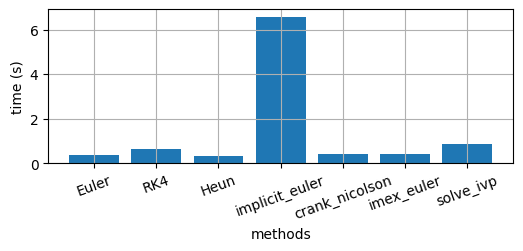

In [68]:
# for each stats object, extract the total time and plot as a bar chart
total_tt = []
num_calls = []
for i, method in enumerate(methods):
    total_tt.append(stats[i].get_stats_profile().total_tt)

plt.figure(figsize=(6,2))
plt.bar(methods, total_tt)
plt.xticks(rotation=20)
plot_help(plt, 'methods', 'time (s)')

In [75]:
# why is implicit euler so slow?
stats[3].sort_stats('calls').print_stats(4)

         1005352 function calls (1005350 primitive calls) in 6.591 seconds

   Ordered by: call count
   List reduced from 60 to 4 due to restriction <4>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   275564    0.041    0.000    0.041    0.000 {built-in method builtins.callable}
   270461    3.774    0.000    3.815    0.000 /Users/philblecher/Desktop/Github/ScientificComputing-EMAT30008/pde_solver.py:221(F)
   270461    0.717    0.000    4.531    0.000 /Users/philblecher/Desktop/Github/ScientificComputing-EMAT30008/pde_solver.py:242(F_solve)
15318/15316    0.022    0.000    0.059    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}




Looking at the breakdown of the implicit euler method shows that cumuluatively the F_solve and its subfunction F take the most time. These functions are used to wrap the problem in such a way that scipy's root can be used to solve the nonlinear system for u. 

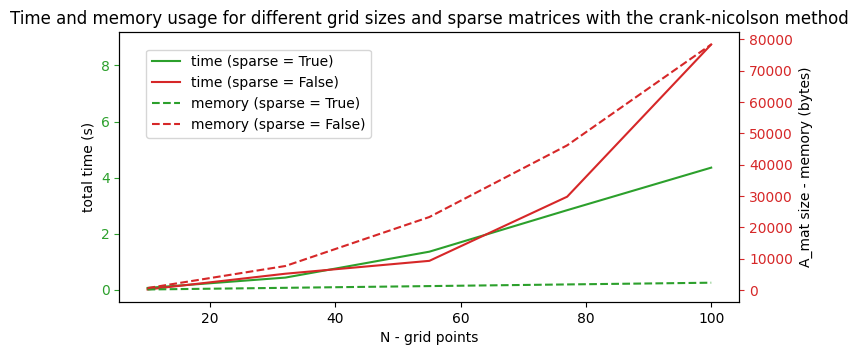

In [77]:
from helpers import help_prof
# one axis for time, one for memory on the same plot and corresponding colours
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax2 = ax.twinx()
for i,sparse in enumerate([True, False]):
    total_t = []
    stor = []
    n_range = np.linspace(10, 100, 5, dtype=int)
    for n in n_range:
        stats, nbytes = help_prof(n, sparse, Solver, pde) # help_prof profiles the solver returns stats and memory usage
        total_t.append(stats.get_stats_profile().total_tt)
        stor.append(nbytes)
    ax.plot(n_range, total_t, label='time (sparse = %s)' %str(sparse), color='C'+str(i+2))
    ax2.plot(n_range, stor, color='C'+str(i+2), linestyle='--', label='memory (sparse = %s)'% str(sparse))
ax.set_xlabel('N - grid points')
ax.set_ylabel('total time (s)')
ax2.set_ylabel('A_mat size - memory (bytes)')
ax.tick_params(axis='y', colors='C2')
ax2.tick_params(axis='y', colors='C3')
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85))
plt.title('Time and memory usage for different grid sizes and sparse matrices with the crank-nicolson method')
plt.show()

The figure above shows the performance improvements for the crank-nicolson method when adding the option of using sparse matrix forms. There is no consistent time improvements for the range of grid points tested, however, the memory saving for the A matrix is significant. This is because the A matrix is a tridiagonal matrix and so can be stored in a sparse form. 

# A description of the key software design decisions made (40% of the marks)

**The key design decisions should be described; explain your thinking behind the overall structure and interfaces of your code. If your code structure is intricate, a block diagram might be appropriate. Why were the solvers implemented as they are? What alternative designs might have been appropriate and why were they not pursued?**

1. How you have modularised your code
    - Steady State Problems (ODEs) and Limit Cycle Problems
    starts with the simple integration methods
    the integration methods then used for integration for a range
    this can then be used in shooting 
    the shooting is a form of discretisation (alongside linear) which can be used in continuation
    continuation is a form of root finding and allows a choice of: type, method (scipy or numpy), step size, max steps, starting point, starting parameter, parameter to vary, discretisation type

    - For PDEs
    first solving a BVP, the bvp_solver module is used, the structure is the same for pde_solver

    the modules allow a problem equation to be defined using either the ODE or PDE object. The problem is then solved using the Solver class which takes the problem, number of interior points and the solving method. The solution is then stored in the solver object and can be accessed using solver.solve().

    by keeping the structure of the modules the same, the code is modular and allows for easy inclusion of new methods and new problems. additionally the solving methods are modular and different methods can be used for different problems just by changing the method in the Solver class.

    This also leads to further development of the code being simple and easy to implement.

    USING CLASSES
    - ODE and PDE objects
    By making class objects for both types of equation, it allows the problem to be set up on initialisation. Making the problem an object allows for the problem to be easily passed to other functions and methods. This is useful for the bvp and pde methods as the problem is passed to the solver class. This also allows for the problem to be easily modified and the solution to be easily accessed.

    - Solver class
    The solver class allows for the solving method to be defined simply and the resulting solution stored in the solver object. This allows for the solution to be easily accessed and the problem to be easily modified.

    - Continuation class
    The continuation class allows for the addition of future continuation methods simply as the input is defined and the output is always the same. This allows for the continuation method to be easily modified and the solution to be easily accessed.
    Additionally, by having well defined inputs and outputs the continuation method works with a variety of equation types adn therefore discretisation methods without any changes to the code.

    - Discretisation class
    The discretisation class allows for the addition of future discretisation methods simply as the input is defined and the output is always the same. Currently the class contains the shooting and linear discretisation methods, this is suitable for limit cycle problems and algebraic equations respectively.

2. How you have tested your code
    The base tests are made for the one step integration methods and the solve_to method as these form the building blocks for all the other methods. By adding these to a github actions workflow, the code is tested every time a push is made to the repository. This allows for the code to be tested and any errors to be fixed before they are merged into the main branch (if there are multiple developers working on the code). 

    As the complexity of the code has increased, the need for error catching has increased. At each input, the code aims to raise errors related to incorrect inputs allowing users to traceback the error and fix it. 

3. How you have documented your code

    Throughout the code, docstrings are used to describe the purpose of the function and the inputs and outputs. This allows for the code to be easily understood and for the user to know what the function does and how to use it. Additionally, examples are included in the docstrings to show how the function can be used.

    The structure of the code is also well documented in the README.md file. This allows for the user to understand the structure of the code and how to use it.

4. How you have made your code user-friendly

    Each function has a docstring which describes the purpose of the function and the inputs and outputs. This allows for the code to be easily understood and for the user to know what the function does and how to use it. Additionally, examples are included in the docstrings to show how the function can be used.

5. How you have made your code efficient
    The code has been developed with the DRY principle in mind. This means that the code is modular and allows for the addition of new methods and problems easily, while having minimal repetition. The development has therefore been efficient. 

    Latest developments have included the addition of classes for discretisation, continuation, ODEs, PDEs and their respective solvers. 

    Additionally, the use of sparse matrices has been implemented for the crank-nicolson method for solving PDEs. This allows for the method to be used for larger problems such that the memory efficiency of this method is much better than other methods.


# A reflective learning log (30% of the marks)

From the Open University reflective thinking can be described as
    thinking with a purpose
    being critical, but not negative
    analysing how effective your learning is
    questioning and probing
    making judgements and drawing conclusions.
    Key questions you should try to answer in your learning log are as follows.
    What did I learn about the mathematical algorithms? I.e., solving boundary value problems, numerical ill-conditioning, etc.
    What did I learn about software engineering? How have I progressed in my abilities?
    What are the short-term implications of what I've learnt? (When will it be useful?)
    What are the long-term implications of what I've learnt? (When will it be useful?)
    What would I have done differently if I started the unit over again?
    What will I do differently in the future?
    You will probably find it helpful to make notes on the answers to these questions each week.

1. What did I learn about the mathematical algorithms?
    Understanding shooting, continuation, integration...

2. What did I learn about software engineering?
    I started by writing plain scripts with small functions to make sure I got a minimum working script, once that worked i went back and re wrote all the files to contain a handful of functions needed to solve the relevant problems. This allowed me to make sure the code worked before adding the complexity of classes and methods. Eventually i went back through the code and added classes to the large problems in order to make them very modular and allow easier addition of new methods and problems.

    Adding classes was simple once the code was working as the functions that existed could be moved into parts of a class. i found that once i made the classes, adding more code to each class became much simpler as all the definitions, inputs and outputs were already defined. This sped up the development process towards the end of the module.

    Additionally, i found that by using github actions, i was able to test the code every time i pushed to the repository. This allowed me to catch errors early and fix them due to the quick notifications I received from github.

    Overall, I found that putting in the hard work of modularising the code early on allowed for the code to be easily developed and new methods and problems to be added easily afterwards. I know that in future software development projects i will aim to outline the inputs and outputs to all the problems I face, in a modular fashion (like classes), prior to writing the code.

3. What are the short-term implications of what I've learnt? (When will it be useful?)
    Short-term, this project ran alongside my dissertation in which I was developing a mathematical model of a hydropower turbine. What I learnt through this module - namely good practice for developement and modularity - transferred into making that model highly modular and parametric with clear inputs and outputs. 

    Additionally, I've gained a greater understanding of github action, continuous integration and testing. This will be useful in future projects as I will be able to test my code as I develop it and catch errors early on. Having the skills to set this up would not have been possible without this unit as I did not know this existed.


4. What are the long-term implications of what I've learnt? (When will it be useful?)
    Long-term, the benefits of what I learnt are very similar. I will be able to develop code in a modular fashion and test it as I go. In the future I aim to work in software development to some extent, therefore having such a clear understanding of good coding practices will be critical. 

    Additionally, the use of existing packages has allowed me to better understand how to use external tools to my advantage during the development and testing of my own projects. Having used many of the modules prior to this project, I thought that I had a good understanding of how to use them. However, through this project I have learnt how to correctly use the documentation and structure of existing modules to both implement them and to structure my code in a similar way.

5. What would I have done differently if I started the unit over again?
    If I started the unit again, I would have started by writing clear plans for each function, thereby allowing inputs, outputs and methods to be clearly defined prior to coding. I did this towards the end of the unit, however, I believe it would have saved a large amount of time if I had done this from the start.

    Additionally, I think it would be beneficial to the coding process, had I implemeted each new feature for a very basic example. In the future, i would therefore try to define a list of simple problems and solutions for each feature of programming that i wish to implement. This would allow every new feature to be tested - this is test-driven development.

    I believe had I had access to more basic examples, i would have developed the code using test-driven development as each input and output for eeach feature could be defined prior to writing the code. This is something I struggled with during the unit, as for many of the features I was unsure of the inputs and outputs until I had written the code.

6. What will I do differently in the future?
    As above, I now believe in test-driven development as a method of development. I will therefore aim to define the inputs and outputs of each feature prior to writing the code. This will allow for the code to be tested as it is written and for errors to be caught early on as well as defining the modular structure early on.

